# Introduction

The goal of this initial analysis is to load data about imports, exports, and domestic production of various food types, relevant to Switzerland. Please see the `README` for overall project goals and background information.

Note that in the current state of analysis, only fruits and vegetables have been considered. Functions for processing the data regarding meats, non-meat animal products, and other food groups have already been written, but this data was not yet incorporated into the notebook, for simplicity purposes and initial exploration.

In [1]:
# import external libraries
%matplotlib inline
import collections
import inspect
import pickle
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

In [2]:
# import local dependencies
from scripts.helpers import *
from scripts.plots import *
from scripts.impex_data_manipulation import *
from scripts.fao_data_manipulation import *
from scripts.emissions_data_manipulation import *
from scripts.data_analysis import *

The first step is to calculate, for each type of food, how much of what is consumed by the Swiss population is produced within Switzerland versus imported. To do this, we will combine 3 sets of data: imports, exports, and domestic production. The imports and exports data are sourced from [Swiss Impex](https://www.gate.ezv.admin.ch/swissimpex/index.xhtml), a website hosted by the Swiss Federal Customs Administration which provides data on Switzerland's global trade activity. Domestic production data comes from [FAOStat](http://www.fao.org/faostat/en/#data), the Food and Agriculture Organization of the United Nations which offers a variety of agricultural-related data. In theory, the amount of food consumed in Switzerland (including food waste) can be calculated from these datasets:

Food consumed = domestic production + imports - exports

Note that the Swiss Federal Statistics Office also provided relevant data--namely, it has a dataset on Swiss food consumption by type of food. Unfortunately, these data conflicted with the data from FAO and Swiss Impex. Since the Federal Statistics Office data was much less detailed (for instance, more general/broad food categories), we decided to focus on Impex and FAO, knowing that the numbers must be taken with a grain of salt since it is difficult to accurately quantify such data.

Let's load all the data and then combine the various data sets to get the values of interest. First we'll load imports and exports data from Impex. The data is spread across multiple Excel files and sheets and we combine them all in a single dataframe.

In [3]:
impex = load_impex()

In [4]:
impex.head()

fruits                                        \
           plantains_and_others                               bananas   
                        imports             exports           imports   
                       quantity      value quantity value    quantity   
total                 1444222.0  1771349.0      2.0   3.0  92397628.0   
Argentina                 396.0      400.0      0.0   0.0         NaN   
Bangladesh                130.0      349.0      0.0   0.0         NaN   
Brazil                   1229.0     1473.0      0.0   0.0      1301.0   
Cameroon                 1529.0     2302.0      0.0   0.0     65786.0   

                                                                  ...  \
                                               dates              ...   
                         exports             imports              ...   
                  value quantity    value   quantity       value  ...   
total       105810538.0  36763.0  50822.0  2706334.0  15719362.0  ...   
Argentina           NaN      NaN      NaN        NaN         NaN  ...   
Bangladesh          NaN      NaN      NaN        NaN         NaN  ...   
Brazil           3662.0      0.0      0.0        NaN         NaN  ...   
Cameroon       164587.0      0.0      0.0        NaN         NaN  ...   

           animal_products                                                 \
                    cheese                     eggs                         
                   exports                  imports               exports   
                  quantity        value    quantity       value  quantity   
total           67285451.0  601005711.0  36298734.0  75561953.0  442894.0   
Argentina              NaN          NaN     23700.0    122918.0       0.0   
Bangladesh             NaN          NaN         NaN         NaN       NaN   
Brazil             17892.0     245202.0         0.0         0.0       0.0   
Cameroon               NaN          NaN         NaN         NaN       NaN   

                                                                   
                           honey                                   
                         imports               exports             
                value   quantity       value  quantity      value  
total       1462812.0  8191947.0  36137446.0  685704.0  7251815.0  
Argentina         0.0  1407193.0   3722676.0       0.0        0.0  
Bangladesh        NaN        NaN         NaN       NaN        NaN  
Brazil            0.0    11907.0     43965.0       0.0        0.0  
Cameroon          NaN        NaN         NaN       NaN        NaN  

[5 rows x 284 columns]

In [5]:
impex_total = pd.DataFrame(impex.iloc[0]).drop("value", level=3).droplevel([0, 3])
impex_total.index = impex_total.index.set_names(["subtype", "metric"])
impex_total.head()

total
subtype              metric             
plantains_and_others imports   1444222.0
                     exports         2.0
bananas              imports  92397628.0
                     exports     36763.0
dates                imports   2706334.0

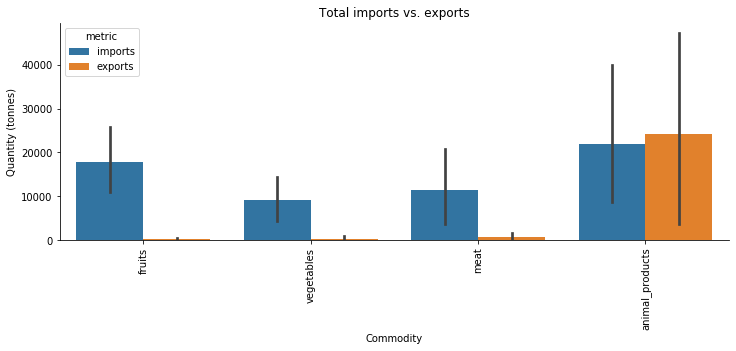

In [6]:
data = pd.DataFrame(impex.iloc[0]).drop("value", level=3).droplevel([1, 3])
data.index = data.index.set_names(["type", "metric"])

data.reset_index(inplace=True)

data["total"] = data.total / 1000

plt.figure(figsize=(12, 4))
ax = sns.barplot(x="type", y="total", hue="metric", data=data)

ax.set(
    title="Total imports vs. exports",
    xlabel="Commodity",
    ylabel="Quantity (tonnes)"
)
plt.xticks(rotation=90)
sns.despine();

As you can see, Switzerland imports many more fruits, vegetables and meat than the country exports. However, this is only part of the broader picture since domestic production is another important consideration.

Let's now load the data on domestic production from FAO:

In [7]:
# only fruits and vegetables for now
fao = load_fao()

In [8]:
fao.head()

,,total
subtype,metric,
agave_fibres_nes,production,0.0
almonds_with_shell,production,0.0
anise_badian_fennel_coriander,production,0.0
apples,production,225622000.0
apricots,production,9420000.0


In [9]:
mega = pd.concat([impex_total, fao]).sort_values("subtype")

In [10]:
# Goal for final milestone: 
# Clean this dataframe and add consumption info:
# 1. domestically produced and consumed
# 2. imported and consumed
mega

total
subtype                       metric                 
agave_fibres_nes              production          0.0
almonds_with_shell            production          0.0
anise_badian_fennel_coriander production          0.0
apples                        exports       3027636.0
                              production  225622000.0
...                                               ...
yautia_(cocoyam)              imports           724.0
                              exports             0.0
                              production          0.0
yogurt                        imports      10281476.0
                              exports       5467769.0

[309 rows x 1 columns]

***

After finishing what is listed in the cell above, we can go further into animal feed.....

One interesting aspect of meat and non-meat animal product production, which is not relevant to the other food groups, is that animal feed may be sourced from a different location than where the meat/animal product is produced. This implicates the sourcing of animal feed as a very important factor for the carbon intensity of these foods. For example, if Switzerland produced most of its meat domestically, but it imported all of its feed, the carbon intensity of its meat would be much higher than if the feed were grown domestically. Thus, both aspects of the final food product must be examined.

Next step will be to examine Swiss production, imports, and exports of *animal feed* (coming up in the next milestone!)

## Emissions


Now that we have calculated Switzerland's production and consumption, we want to have a look at how this translates in terms of equivalent CO$_2$ production. To do this, we could look at Swiss-specific values for the greenhouse gas production for different food types, however data from other countries is very sparse and reliable data for many food types is only available for certain countries. Later in the analysis, we want to compare Swiss production emissions with Swiss import emissions, therefore for consistency we need to either have data available for all (or most) countries for a given product, or use global averages. Comprehensive data is available on meat and cereal production emissions worldwide, however fruit and vegetable figures are much harder to obtain and only a limited number of studies have been carried out. These studies have been accumulated in a systematic review (https://www.sciencedirect.com/science/article/pii/S0959652616303584) and these values have been used to calculate averages for a number of different kinds of produce. To ensure our results are consistent, we will use this generalisation of global average values to estimate the domestic Swiss emissions for fruit and vegetables.

<!---
Other thought: I've currently created a dictionary to map the different fruit/veg to the impex categories. Was just thinking, this could be a potential spot to use machine learning, although admittedly not a very useful one...
--->

In [11]:
emissions = load_emissions()
emissions.head()

,Median,Mean,Stdev,Deviation from mean,Min,Max,Q1,Q3,No. of LCA studies,No. of GWP values,Category
Name,,,,,,,,,,,
Onion,0.17,0.18,0.11,0.60,0.06,0.37,0.10,0.21,7,9,onions_garlic_shallots_leeks
Celery,0.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,onions_garlic_shallots_leeks
Potatoes,0.18,0.20,0.08,0.41,0.08,0.36,0.16,0.26,16,25,potatoes
Carrots,0.20,0.22,0.15,0.65,0.04,0.50,0.11,0.31,10,13,edible_roots
Zucchini/button squash,0.21,0.42,0.50,1.21,0.09,1.17,0.16,0.46,3,4,other


The food names in the above dataframe need to be mapped to the format of the production, imports and exports dataframe above. Taking an example dataframe containing consumption within Switzerland of Swiss produced products (Domestic Consumption), consumption of imported products (Imported Consumption) and Total Consumption (in thousand tonnes per year), we can use the above values to estimate the emissions resulting from the production of food consumed in Switzerland.

In [12]:
pretend = {"Product":["Onion","Beetroot"], "Domestic Consumption":[1000,2000], "Imported Consumption":[2000,4000], "Total Consumption":[3000,6000]}
domestic = pd.DataFrame.from_dict(pretend)

So assuming that domestic transport is negligible, we can estimate the equivalent CO$_2$ emissions for each product type, using the global average values.

In [13]:
# TODO update this code to work with merged dataframe above + include all categories
domestic = estimate_emissions(domestic, emissions)

In [14]:
domestic

,Product,Domestic Consumption,Imported Consumption,Total Consumption,Domestic Equivalent CO2,Imported Equivalent CO2,Total Equivalent CO2
0,Onion,1000,2000,3000,180000000.0,360000000.0,5.400000e+08
1,Beetroot,2000,4000,6000,460000000.0,920000000.0,1.380000e+09


The final column of the above table shows the total CO$_2$ equivalent that would be produced if everything that was consumed in Switzerland was domestically produced, i.e. no transport emissions were considered and Swiss-specific CO$_2$ emissions were used for meat and cereal production. Evidently, it is not possible to produce everything that a current consumer buys locally, so in the following analysis we will consider the effect that these imported products and 'food miles' have on the CO$_2$ emissions resulting from Swiss consumption. 

The following will describe initial observations we have made regarding the transport of food, global carbon emissions intensities, and how we plan to use this information to estimate the impact consumption of different foods in Switzerland has and how a Swiss consumer can minimise their environmental impact in their food choices.

## Further Analysis

'Food miles', or the distance that food has to travel to arrive on your plate, clearly have an impact on the carbon emissions of the products we consume. Let's look at how much of the food, beverages, and tobacco that Switzerland imports comes from its nearest neighboring countries. The farther a country is, the more carbon emissions it would cost to import that food.

In [15]:
percentage = glimpse()
print(str(round(percentage)) + "% of Switzerland's total imports come from countries within a 1000km radius.")

76.0% of Switzerland's total imports come from countries within a 1000km radius.


So we can see that a lot of Switzerland's imports come from nearby countries. We will continue in this vein and look at the origins of each product individually to see the impact these food miles/varying production methods have on their carbon footprint. One thing we will consider is the transport methods, clearly the impact of these food miles differs greatly depending on whether the food is transported by plane or ship...

In [16]:
from IPython.display import Image
Image(url = "https://icmattermost.epfl.ch/files/5zr1jyriupfsfgmr4dtg155ssw/public?h=_GPk0xYK1I16gWsY3GuIsrFC5bTb3Ioh4_W3h3oYDs8", width=400,height=300)

Transport methods for different commodoties in the USA are described in detail in the paper *Food-Miles and the Relative Climate Impacts of Food Choices in the United States* (Weber and Matthews, 2008). These values, or similar data for other countries worldwide could be used to estimate the transport means for different products and thus the impact this transport has on emissions for each product. Perishable products more frequently have to be transported by air, and therefore have a significantly larger carbon footprint.